In [1]:
# import packages

# general tools
import numpy as np

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split 
import math
import matplotlib.pyplot as plt

In [2]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

In [9]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = False):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]
    
    #atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
    atom_feature_vector = atom_type_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled 
    print(permitted_list_of_atoms)
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [4]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [5]:
df = pd.read_csv("250k_rndm_zinc_drugs_clean_3.csv")
smiles = df["smiles"]
y = df["qed"]

In [10]:
mol = Chem.MolFromSmiles(smiles[0])
get_atom_features(mol.GetAtomWithIdx(0))

['H', 'C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']


array([0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01032802, 1.        ,
       0.        , 0.        , 0.        ])

In [106]:
def convert_smiles_to_matrix(smiles):
    matrix = []
    for smile in tqdm(smiles):
        #Chem.MolFromSmiles(smiles[0]).GetBondBetweenAtoms(0, len()).GetSymbol()
        mol = Chem.MolFromSmiles(smile)
        total_atoms = len(mol.GetAtoms())-1
        # atom hotencoding
        atom_encoding = []
        for i in range(total_atoms):
            if len(atom_encoding) > 0:
                atom_encoding += get_atom_features(mol.GetAtomWithIdx(i))
            else:
                atom_encoding = get_atom_features(mol.GetAtomWithIdx(i))
        bond_encoding = []
        for bonds in mol.GetBonds():
            if len(bond_encoding) > 0:
                bond_encoding += get_bond_features(bonds)
            else :
                bond_encoding = get_bond_features(bonds)
        data = list(atom_encoding) + list(bond_encoding)
        matrix.append(data)
    matrix = np.array(matrix)
    return matrix

In [107]:
X = convert_smiles_to_matrix(smiles)
X.shape

  0%|          | 0/249455 [00:00<?, ?it/s]

100%|██████████| 249455/249455 [03:08<00:00, 1321.85it/s]


(249455, 68)

In [108]:
# Define the ANN model for tokenizing with specific input and output sizes using Sequential
class TokenizerANN(nn.Module):
    def __init__(self, input_size, output_size):
        
        super(TokenizerANN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),  # First hidden layer
            nn.ReLU(),
            nn.Linear(256, 256),       # Third hidden layer
            nn.ReLU(),
            nn.Linear(256, 128),       # Fourth hidden layer
            nn.ReLU(),
            nn.Linear(128, 128),        # Fifth hidden layer
            nn.ReLU(),
            nn.Linear(128, output_size) ,
            nn.Softmax()# Encoder output layer
        )
       
        self.decoder = nn.Sequential(
            nn.Linear(output_size, 128),          # Decoder input layer
            nn.ReLU(),
            nn.Linear(128, 128),        # First hidden layer
            nn.ReLU(),
            nn.Linear(128, 256),       # Second hidden layer
            nn.ReLU(),
            nn.Linear(256, 256),       # Third hidden layer
            nn.ReLU(),
            nn.Linear(256, input_size)   # Decoder output layer
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [109]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [110]:
from torchsummary import summary

In [111]:
# Sample data
batch_size = 32
target_size = 4

# Training loop
num_epochs = 150

X_train, X_test, y_train, y_test = train_test_split(X, X, 
                                   random_state=104,  
                                   test_size=0.4,  
                                   shuffle=True) 

tensor_X_train = torch.from_numpy(X_train).to(device)
tensor_X_test = torch.from_numpy(X_test).to(device)
tensor_y_train = torch.from_numpy(y_train).to(device)
tensor_y_test = torch.from_numpy(y_test).to(device)

# Create DataLoader
dataset = TensorDataset(tensor_X_train, tensor_y_train)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = TokenizerANN(input_size = tensor_X_test.shape[1],
                     output_size=target_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# define history list
class history:
    def __init__(self) -> None:
        self.loss = []
        self.val_loss = []
        self.metric_loss = []
        self.val_metric_loss = []
h = history()

summary(model, (batch_size, tensor_X_test.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 256]          17,664
              ReLU-2              [-1, 32, 256]               0
            Linear-3              [-1, 32, 256]          65,792
              ReLU-4              [-1, 32, 256]               0
            Linear-5              [-1, 32, 128]          32,896
              ReLU-6              [-1, 32, 128]               0
            Linear-7              [-1, 32, 128]          16,512
              ReLU-8              [-1, 32, 128]               0
            Linear-9                [-1, 32, 4]             516
          Softmax-10                [-1, 32, 4]               0
           Linear-11              [-1, 32, 128]             640
             ReLU-12              [-1, 32, 128]               0
           Linear-13              [-1, 32, 128]          16,512
             ReLU-14              [-1, 

c:\Users\Evint\Documents\Projects\Functional-Group-Analysis\venv\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [112]:
min_loss = 1e5
hist_loss = []
hist_val_loss = []
for epoch in range(num_epochs):
    loss_acc = []
    for inputs, targets in data_loader:
        optimizer.zero_grad()
        outputs = model(torch.tensor(inputs, dtype=torch.float32))
        loss = criterion(outputs, targets.to(torch.float32))
        loss.backward()
        optimizer.step()
        loss_acc.append(loss.item())
    
    epoch_loss = np.mean(loss_acc)
    val_outputs = model(torch.tensor(tensor_X_test, dtype=torch.float32))
    val_loss = criterion(val_outputs, tensor_y_test)
    hist_loss.append(epoch_loss.item())
    hist_val_loss.append(val_loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}; val_loss: {val_loss:.4f}", end=" ")
    if min_loss > epoch_loss:
        torch.save(model.state_dict(), "tokenizer_ann_with_decoder.pth")
        min_loss = epoch_loss
        print("saved")
    else:
        print()

C:\Users\Evint\AppData\Local\Temp\ipykernel_38116\3657820513.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(inputs, dtype=torch.float32))
C:\Users\Evint\AppData\Local\Temp\ipykernel_38116\3657820513.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(tensor_X_test, dtype=torch.float32))


Epoch [1/350] - Loss: 1.9349; val_loss: 0.4068 saved
Epoch [2/350] - Loss: 0.2917; val_loss: 0.2156 saved
Epoch [3/350] - Loss: 0.2043; val_loss: 0.2012 saved
Epoch [4/350] - Loss: 0.1995; val_loss: 0.1955 saved
Epoch [5/350] - Loss: 0.1960; val_loss: 0.1937 saved
Epoch [6/350] - Loss: 0.1919; val_loss: 0.1890 saved
Epoch [7/350] - Loss: 0.1871; val_loss: 0.1838 saved
Epoch [8/350] - Loss: 0.1817; val_loss: 0.1795 saved
Epoch [9/350] - Loss: 0.1762; val_loss: 0.1716 saved
Epoch [10/350] - Loss: 0.1716; val_loss: 0.1704 saved
Epoch [11/350] - Loss: 0.1675; val_loss: 0.1704 saved
Epoch [12/350] - Loss: 0.1641; val_loss: 0.1593 saved
Epoch [13/350] - Loss: 0.1609; val_loss: 0.1573 saved
Epoch [14/350] - Loss: 0.1596; val_loss: 0.1564 saved
Epoch [15/350] - Loss: 0.1564; val_loss: 0.1544 saved
Epoch [16/350] - Loss: 0.1543; val_loss: 0.1686 saved
Epoch [17/350] - Loss: 0.1507; val_loss: 0.1489 saved
Epoch [18/350] - Loss: 0.1479; val_loss: 0.1454 saved
Epoch [19/350] - Loss: 0.1460; val_lo

KeyboardInterrupt: 

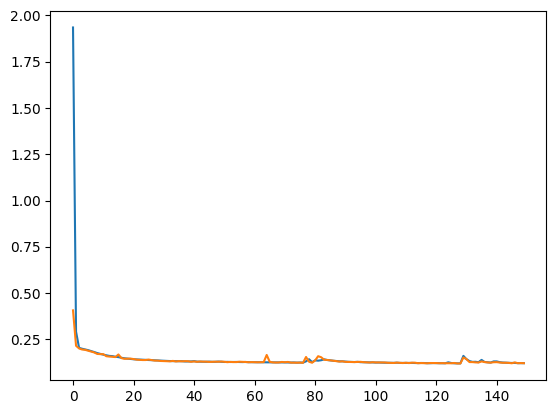

In [113]:
plt.plot(hist_loss)
plt.plot(hist_val_loss)